A script using gdal for substracting two dem that dont have the same extend. First you need to load the dems in the code below in the forst cell.
Then speficy the path for the saved files. 

In [1]:
from osgeo import gdal, gdalconst
import numpy as np

def align_dems(base_dem_path, target_dem_path, aligned_dem_path):
    # Open base DEM (reference) and get its properties
    base_dem = gdal.Open(base_dem_path, gdalconst.GA_ReadOnly)
    base_dem_proj = base_dem.GetProjection()
    base_dem_geotrans = base_dem.GetGeoTransform()
    base_dem_xsize = base_dem.RasterXSize
    base_dem_ysize = base_dem.RasterYSize
    base_dem_nodata = base_dem.GetRasterBand(1).GetNoDataValue()

    # Open the target DEM
    target_dem = gdal.Open(target_dem_path, gdalconst.GA_ReadOnly)
    target_dem_nodata = target_dem.GetRasterBand(1).GetNoDataValue()

    # Create a new aligned DEM file
    driver = gdal.GetDriverByName('GTiff')
    aligned_dem = driver.Create(aligned_dem_path, base_dem_xsize, base_dem_ysize, 1, target_dem.GetRasterBand(1).DataType)
    aligned_dem.SetProjection(base_dem_proj)
    aligned_dem.SetGeoTransform(base_dem_geotrans)

    # Set NoData value for aligned DEM
    nodata_value = target_dem_nodata if target_dem_nodata is not None else base_dem_nodata
    aligned_dem.GetRasterBand(1).SetNoDataValue(nodata_value)

    # Perform the alignment/resampling
    gdal.ReprojectImage(target_dem, aligned_dem, target_dem.GetProjection(), base_dem_proj, gdalconst.GRA_Bilinear)

    # Close the datasets
    base_dem = None
    target_dem = None
    aligned_dem = None

    # Modify the aligned DEM to set 0 values to NoData
    modify_dem(aligned_dem_path, nodata_value)

def modify_dem(dem_path, nodata_value):
    # Open the aligned DEM
    dem = gdal.Open(dem_path, gdalconst.GA_Update)
    band = dem.GetRasterBand(1)
    data = band.ReadAsArray()

    # Set 0 values to NoData
    data[data == 0] = nodata_value

    # Write the modified array back to the DEM
    band.WriteArray(data)

    # Close the dataset
    dem = None

def subtract_dems(base_dem_path, aligned_dem_path, subtracted_dem_path):
    # Open the base (reference) DEM
    base_dem = gdal.Open(base_dem_path)
    base_band = base_dem.GetRasterBand(1)
    base_array = base_band.ReadAsArray()

    # Open the aligned DEM
    aligned_dem = gdal.Open(aligned_dem_path)
    aligned_band = aligned_dem.GetRasterBand(1)
    aligned_array = aligned_band.ReadAsArray()

    # Perform subtraction (aligned DEM minus base DEM)
    nodata_value = base_band.GetNoDataValue()
    difference = np.where((base_array == nodata_value) | (aligned_array == nodata_value), nodata_value, aligned_array - base_array)

    # Create a new raster file for the subtracted DEM
    driver = gdal.GetDriverByName('GTiff')
    subtracted_dem = driver.Create(subtracted_dem_path, base_dem.RasterXSize, base_dem.RasterYSize, 1, gdal.GDT_Float32)
    subtracted_dem.SetProjection(base_dem.GetProjection())
    subtracted_dem.SetGeoTransform(base_dem.GetGeoTransform())

    # Write the difference array to the new DEM file
    subtracted_band = subtracted_dem.GetRasterBand(1)
    subtracted_band.SetNoDataValue(nodata_value)
    subtracted_band.WriteArray(difference)

    # Close the datasets
    base_dem = None
    aligned_dem = None
    subtracted_dem = None

# Specify your DEM file paths
base_dem_path = r"D:\Bylot\summer_2017\Blocs\2017_ravin_DEM.tif"
target_dem_path = r"D:\Bylot\Summer_2022\Blocs\ravin_dsm_2022_corrected.tif"
aligned_dem_path = r"D:\Bylot\Summer_2022\Blocs\ravin_corrige_aligned4.tif"
subtracted_dem_path = r"D:\Bylot\ravin_difference4.tif"

# Align the DEMs
align_dems(base_dem_path, target_dem_path, aligned_dem_path)

# Subtract the aligned DEM from the base DEM
subtract_dems(base_dem_path, aligned_dem_path, subtracted_dem_path)

print("DEM alignment, modification, and subtraction complete.")




c:\Users\Thierry\.conda\envs\geospatial\Lib\site-packages\osgeo\gdal.py:287: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


DEM alignment, modification, and subtraction complete.


Here is the code to plot the difference with a histogram using matplolib

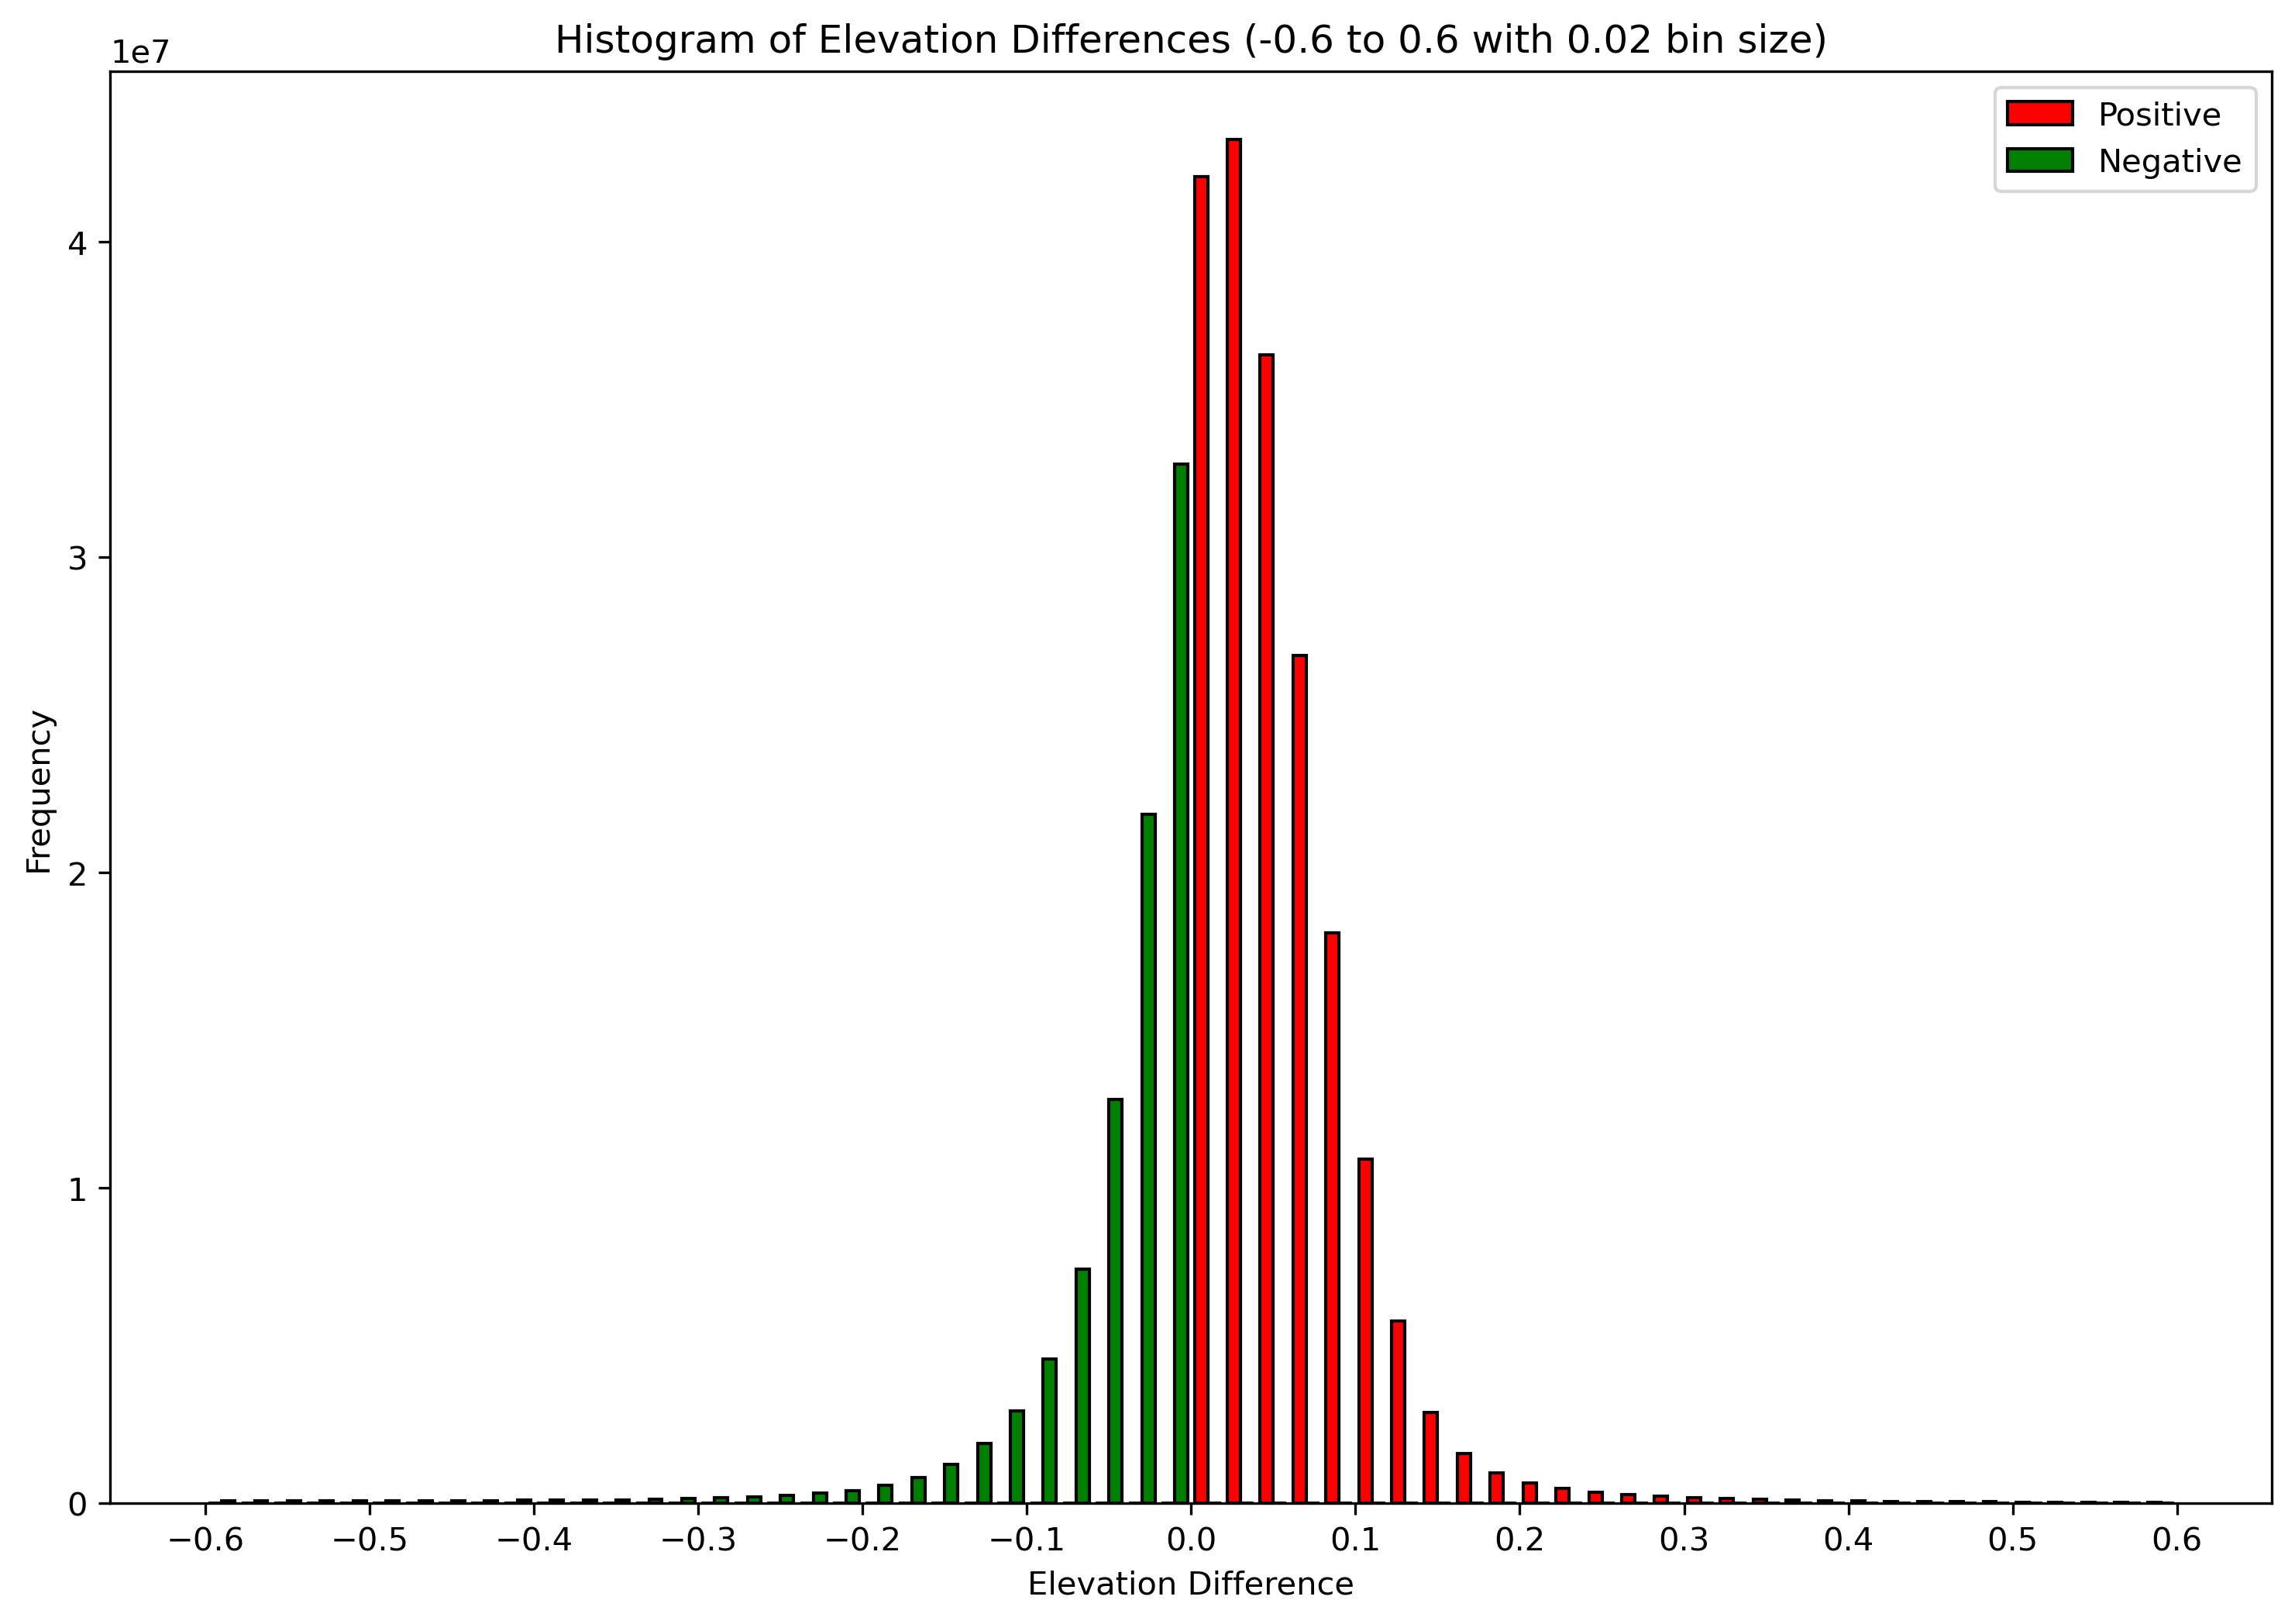

In [2]:
#Load the libraries
import rasterio as rio
import matplotlib.pyplot as plt
import numpy as np

# Specify the path to the subtracted DEM file
subtracted_dem_path = r"D:\Bylot\ravin_difference4.tif"

# Open the DEM with Rasterio
with rio.open(subtracted_dem_path) as src:
    elevation_difference = src.read(1)
    # Set masked or NoData values to np.nan
    nodata_value = src.nodata
    elevation_difference[elevation_difference == nodata_value] = np.nan

# Flatten the array and remove NaN values for statistics
flattened_elevation = elevation_difference.flatten()
flattened_elevation = flattened_elevation[~np.isnan(flattened_elevation)]

# Compute basic statistics
mean_difference = np.mean(flattened_elevation)
median_difference = np.median(flattened_elevation)
std_deviation = np.std(flattened_elevation)
min_difference = np.min(flattened_elevation)
max_difference = np.max(flattened_elevation)

# Round the statistics to two decimal places
mean_difference = round(mean_difference, 2)
median_difference = round(median_difference, 2)
std_deviation = round(std_deviation, 2)
min_difference = round(min_difference, 2)
max_difference = round(max_difference, 2)

# Define the bin range from -0.6 to 0.6 with a bin size of 0.02
bin_range = np.arange(-0.6, 0.62, 0.02)

# Separate positive and negative elevation differences
positive_elevation = flattened_elevation[flattened_elevation > 0]
negative_elevation = flattened_elevation[flattened_elevation < 0]

# Create histograms for positive and negative values
plt.figure(figsize=(12, 8), dpi=300)
plt.hist([positive_elevation, negative_elevation], bins=bin_range, color=['red', 'green'], edgecolor='black', label=['Positive', 'Negative'])
plt.title('Histogram of Elevation Differences (-0.6 to 0.6 with 0.02 bin size)')
plt.xlabel('Elevation Difference')
plt.ylabel('Frequency')
plt.xticks(np.arange(-0.6, 0.62, 0.1))
plt.legend()
plt.show()


Print the statistics:

In [3]:
print(f"Mean Difference: {mean_difference}")
print(f"Median Difference: {median_difference}")
print(f"Standard Deviation: {std_deviation}")
print(f"Minimum Difference: {min_difference}")
print(f"Maximum Difference: {max_difference}")

Mean Difference: 0.019999999552965164
Median Difference: 0.019999999552965164
Standard Deviation: 0.12999999523162842
Minimum Difference: -22.049999237060547
Maximum Difference: 1.4199999570846558


Plot the result raster of the Delta z

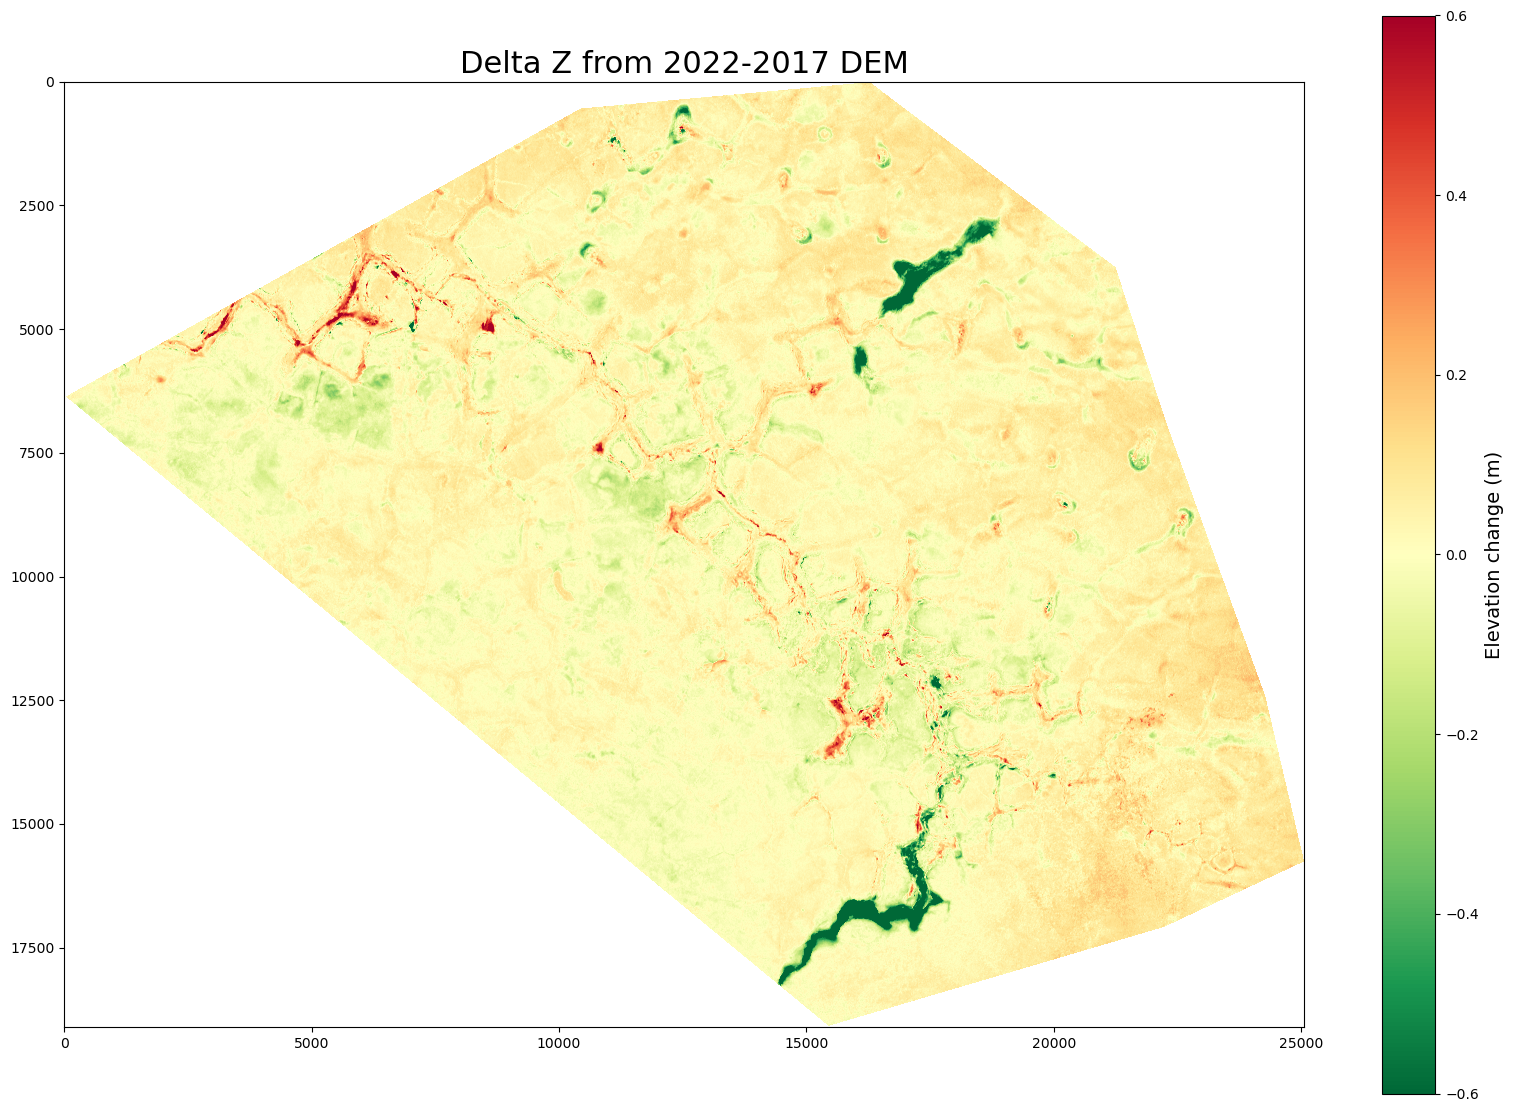

In [4]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

#Load the subtracted DEM
subtracted_dem_path = r"D:\Bylot\ravin_difference4.tif"

with rasterio.open(subtracted_dem_path) as dem:
    dem_data = dem.read(1)  # Read the first band
    nodata = dem.nodata  # Get the NoData value

# Mask the NoData values
dem_data_masked = np.ma.masked_where(dem_data == nodata, dem_data)

# Plotting
plt.figure(figsize=(20, 14))
plt.imshow(dem_data_masked, cmap="RdYlGn_r", vmin=-0.6, vmax=0.6)  # Using original "coolwarm" colormap
cbar = plt.colorbar(label="Delta z (m)")
cbar.ax.tick_params(labelsize=10)
cbar.set_label("Elevation change (m)", size=14)# Change font size of color bar ticks
plt.title("Delta Z from 2022-2017 DEM", fontsize=22)  # Change title font size
#plt.xlabel(fontsize=12)
#plt.ylabel(fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.savefig(r"D:\Bylot\ravin_dem_difference.jpeg", dpi=300)